# Creating a radial chart from timesheet data  
  
Based on [this example - 'Cracking Your Favourite Password' by Cédric Scherer/Tomás Capretto](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/src/notebooks/web-circular-lollipop-plot-with-matplotlib.ipynb)

### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Fetching the data

In [2]:
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,date,client,subproject,type,hours,billable,invoiced,days,day,month,year,period,notes,notes 2,Unnamed: 14
0,869,31-Mar-24,publishing,Qr series book 2,first draft,2.00,no,no,0.285714,31,3,2024,2024.3,NaN,NaN,NaN
1,870,02-Apr-24,publishing,Qr series book 2,marketing,3.50,no,no,0.500000,2,4,2024,2024.4,NaN,NaN,NaN
2,871,02-Apr-24,publishing,Qr series book 1,marketing,3.00,no,no,0.428571,2,4,2024,2024.4,NaN,NaN,NaN
3,872,04-Apr-24,publishing,Qr series book 1,marketing,5.25,no,no,0.750000,4,4,2024,2024.4,NaN,NaN,NaN
4,875,07-Apr-24,publishing,QR series graphic novel,outline,1.00,no,no,0.142857,7,4,2024,2024.4,NaN,NaN,NaN


### Preparing the data

In [3]:
# selecting relevant data from the dataframe 
# I don't need all of the entries, just the ones that relate 
# to the current WIP and are in 2024

df = df[df['subproject'] == 'Qr series book 2']
df=df[df['year'] == 2024]

# also I won't need most of the columns 
# really only the date and the total number of hours for each day
# but before I remove the sub-categories I use `groupby` 
# to capture some summary tables for later reference.

total_hours = df['hours'].sum() # a variable we'll use later
df_sum = df['hours'].groupby(df['type']).sum().reset_index() # the total number of hours spent on each activity

In [4]:
# formatting dates and reshaping the data
# so we have one row per day
df = df[['date','hours']]
df['date'] = pd.to_datetime(df['date'])
df = df.groupby(['date']).sum()
print("The dataset is %d rows." % len(df))

The dataset is 126 rows.


/var/folders/sb/jkwb058s64g88f4xv1qm4mww0000gn/T/ipykernel_24555/2421062592.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [5]:
#I don't get time to write every single day, 
# so in 2024 there are only 126 entries.  
# If I want to visualise a full year, with every single day represented even if the 
# number of hours is zero, I'll need to create a new series with all of the dates in the year 
# and merge it with my data.

mydates = pd.date_range('01-01-2024','12-31-2024',freq='d')
df_cal = pd.DataFrame(mydates)
df_cal.rename(columns={0: "caldate"}, inplace=True)
df_new = df_cal.merge(df, left_on='caldate', right_on='date', how="left")

### Adding information for labels and formatting

In [6]:
from datetime import datetime

# adding new columns for day name and day number so I can define colour categories
# in particular I want to have weekdays and weekends shown in different colours 
# so I can see what the cadence or cycle of effort looks like.

df_new['dayname'] = df_new['caldate'].apply(lambda x: x.strftime('%A'))
df_new['daynum'] = df_new['caldate'].apply(lambda x: x.weekday())

# filling zero values with a small number
# (0.08333 = five minutes that I spend feeling guilty 
# for not having looked at my manuscript that day!)
# because if any day in the data has no writing hours logged
# I don't want it to just be a blank space on the axis

df_new.fillna(0.08333, inplace=True) # 

# add a column for `monthname` but only assign a value if it's the first day of the month. 
# that means I can use the index value to place them in the correct locations on the chart later.
df_new['monthlabel'] = df_new['caldate'].apply(lambda x: x.month_name() if x.day == 1 else np.NaN)
df_new.head(7)

,caldate,hours,dayname,daynum,monthlabel
0,2024-01-01,0.08333,Monday,0,January
1,2024-01-02,0.08333,Tuesday,1,NaN
2,2024-01-03,0.08333,Wednesday,2,NaN
3,2024-01-04,0.08333,Thursday,3,NaN
4,2024-01-05,0.08333,Friday,4,NaN
5,2024-01-06,0.08333,Saturday,5,NaN
6,2024-01-07,0.08333,Sunday,6,NaN


### Constructing the chart   

In [7]:
# we need a scale for the y-axis
# so we take the `hours` column and turn it into a series
# then get a minimum and a maximum value to define the range.   

TIMES = df_new['hours']
TIME_MAX = np.max(TIMES)
TIME_MIN = np.min(TIMES)

# Values for the x axis
ANGLES = np.linspace(0, 2 * np.pi, len(TIMES), endpoint=False)

# Heights of the lines are given by the times.
HEIGHTS = np.array(TIMES)

# Category values for the colors
# because we want to use line colour to differentiate between weekends and weekdays
# we define categories using the `daynum` column values
# these are just integers from 0 to 6 
# with 0 being Monday and 6 being Sunday. 

CATEGORY_CODES = pd.Categorical(df_new["daynum"]).codes

# By default I use CSS colour names at this stage
# firstly because they're easier to remember compared to hex codes 
# and secondly because I use certain combinations often enough to have 
# an idea of what might work together
# (and if I'm wrong, they're easy to change!)

WEEKDAY = "black"
WEEKEND = "coral"

# Week starts on Monday
COLORMAP = [WEEKDAY, WEEKDAY, WEEKDAY, WEEKDAY, WEEKDAY, WEEKEND, WEEKEND]

# Select colors for each day according to its category.
COLORS = np.array(COLORMAP)[CATEGORY_CODES]

# Create a data frame with the month name and date for the first of each month
LABELS_DF = df_new.dropna(how='any').reset_index() # only keeping the non-null values

### Plotting the chart

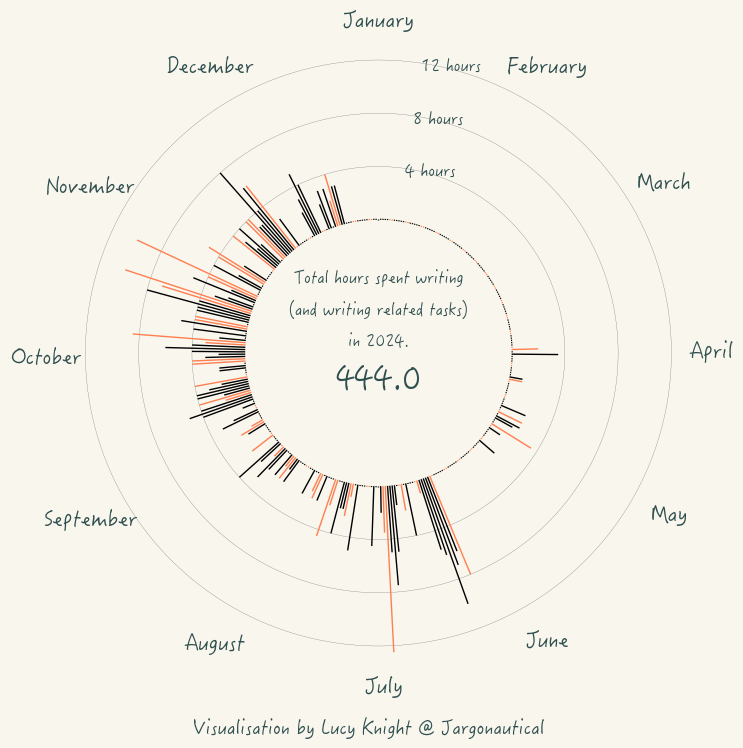

In [8]:
#Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("#f9f6ee")
ax.set_facecolor("#f9f6ee")

# Start by removing spines, grid lines, ticks, and tick labels
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

PLUS = 10

HANGLES = np.linspace(0, 2 * np.pi, 200)
ax.plot(HANGLES, np.repeat(4 + PLUS, 200), color="dimgray", lw=0.2)
ax.plot(HANGLES, np.repeat(8 + PLUS, 200), color="dimgray", lw=0.2)
ax.plot(HANGLES, np.repeat(12 + PLUS, 200), color="dimgray", lw=0.2)

# Add lines
ax.vlines(ANGLES, 0 + PLUS, HEIGHTS + PLUS, color=COLORS, lw=1)
ax.text(x=0.15, y=3.5 + PLUS, s="4 hours", size=12, color ="darkslategray", font="HanziPen SC")
ax.text(x=0.15, y=7.5 + PLUS, s="8 hours", size=12, color ="darkslategray", font="HanziPen SC")
ax.text(x=0.15, y=11.5 + PLUS, s="12 hours", size=12, color ="darkslategray", font="HanziPen SC")

# Add labels for the months
for idx, row in LABELS_DF.iterrows():
    color = 'darkslategray'
    ax.text(
        x=ANGLES[row["index"]], y=15 + PLUS, s=row["monthlabel"],
        ha="center", va="center", ma="center", size=16, color='darkslategray',
        weight="bold", font="HanziPen SC"
    )

# Add text to the centre of the plot

ax.text(
    x=0.5, y=0.56, s="Total hours spent writing\n\n(and writing related tasks)\n\nin 2024.\n",
    color='darkslategray', va="center", ha="center",  ma="center",
    fontsize=12, linespacing=0.87, transform=ax.transAxes, font="HanziPen SC"
)

ax.text(
    x=0.5, y=0.46, s=total_hours,
    color='darkslategray', va="center", ha="center",  ma="center",
    fontsize=24, linespacing=0.87, transform=ax.transAxes, font="HanziPen SC"
)

# Add a caption at the bottom

fig.text(
    x=0.5, y=0.02, s="Visualisation by Lucy Knight @ Jargonautical",
    color='darkslategray', fontsize=14, ha="center", fontweight="bold", font="HanziPen SC"
)

plt.show()

### Adding a category breakdown

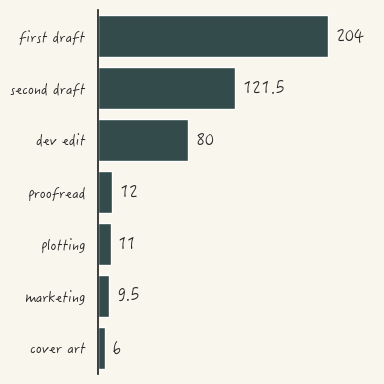

In [9]:
df_sum = df_sum.sort_values(by='hours', ascending=False)
import seaborn as sns
sns.set_theme(style="white", font="HanziPen SC", rc={'figure.figsize':(4,4), 'axes.facecolor':'#f9f6ee', 'figure.facecolor':'#f9f6ee'})
ax = sns.barplot(x=df_sum['hours'],
                 y=df_sum['type'],
                 color="darkslategray",  
                 orient='h')
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xticklabels([])
ax.bar_label(ax.containers[0], padding=5)
ax.margins(x=0.2)
sns.despine(bottom=True)
plt.tight_layout()
plt.show()